# Customer Churn Prediction and Analysis


This project aims to predict which customers are more likely to discontinue their subscription service, also known as churn prediction. Using the Telco Customer Churn dataset from Kaggle, I will apply data analysis techniques to classify customers as “returned” or “churned”. The dataset includes information regarding the customers’ demographics, the services they subscribed to, whether the customer left within the last month, and account information. The goal is to compare simple machine learning models with a deep learning approach to see which provides better predictions and business insights.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. Loading the Dataset
df = pd.read_csv('dataset/Telco-Customer-Churn.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

In [3]:
# 2. Data preprocessing
df["churn"] = LabelEncoder().fit_transform(df["churn"])

# One-hot coding
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop("churn", axis=1)
y = df["churn"]

# Create an imputer to replaces NaN with the column mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Features scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessing complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"NaN values? {pd.isna(X_train).any()}")

Data preprocessing complete.
Training set shape: (80000, 210)
Test set shape: (20000, 210)
NaN values? False


Dataset shape: (100000, 211)

Data types:
rev_Mean       float64
mou_Mean       float64
totmrc_Mean    float64
da_Mean        float64
ovrmou_Mean    float64
ovrrev_Mean    float64
vceovr_Mean    float64
datovr_Mean    float64
roam_Mean      float64
change_mou     float64
dtype: object

Missing values per column:
numbcars       49366
lor            30190
income         25436
adults         23019
avg6rev         2839
avg6qty         2839
avg6mou         2839
rv              1732
forgntvl        1732
truck           1732
change_mou       891
change_rev       891
hnd_price        847
totmrc_Mean      357
ovrmou_Mean      357
dtype: int64
Churn Rate: 49.56%


C:\Users\anhth\AppData\Local\Temp\ipykernel_15504\3314583481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="churn", data=df, palette="coolwarm")


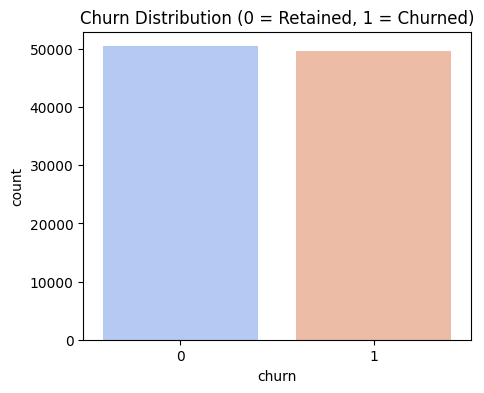

In [4]:
# 2.1. Data exploration
# Check dataset dimensions and types
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes.head(10))

# Look at missing values
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(15))

# Churn distribution
print(f"Churn Rate: {y.mean():.2%}")
plt.figure(figsize=(5,4))
sns.countplot(x="churn", data=df, palette="coolwarm")
plt.title("Churn Distribution (0 = Retained, 1 = Churned)")
plt.show()

Logistic Regression
Accuracy: 0.592
F1 Score: 0.590
ROC AUC: 0.592

Random Forest
Accuracy: 0.617
F1 Score: 0.628
ROC AUC: 0.617



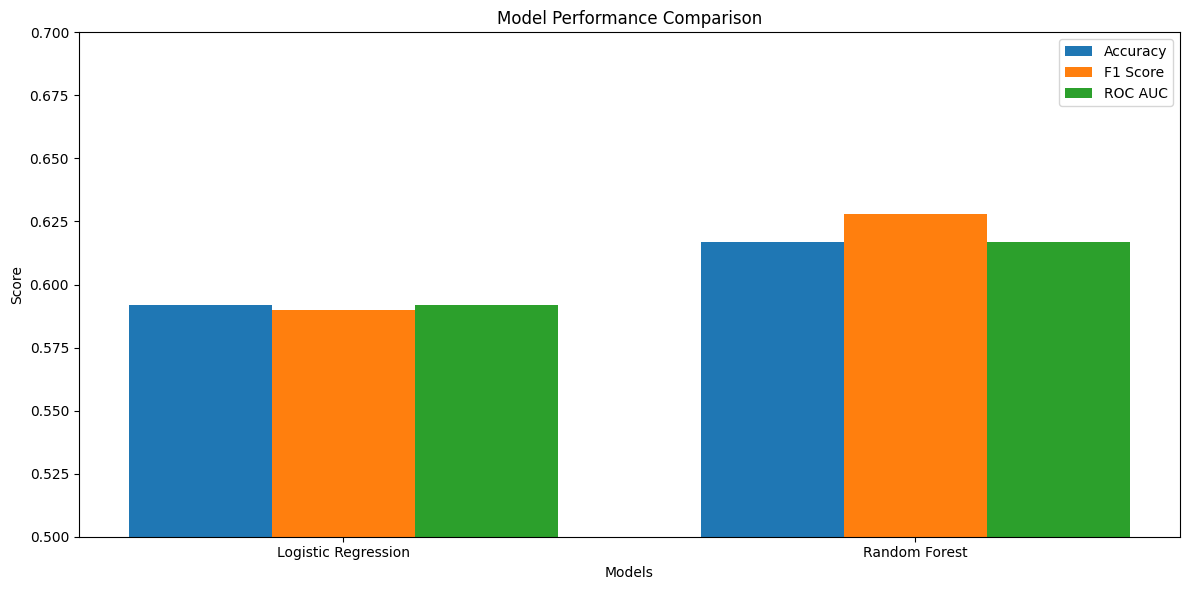

In [5]:
# 3. Baseline models
# Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=-1) #Use all CPU cores for parallel training
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1,      # use all CPU cores
    max_depth = 10) # limit tree depth to prevent overfitting
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 3.1. Model evaluation
for name, preds in [('Logistic Regression', lr_preds), ('Random Forest', rf_preds)]:
    print(f"{name}")
    print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
    print(f"F1 Score: {f1_score(y_test, preds):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, preds):.3f}\n")

# 3.2. Compare baseline models results
models_list = ['Logistic Regression', 'Random Forest']
metrics = {
    'Accuracy': [0.592, 0.617],
    'F1 Score': [0.590, 0.628],
    'ROC AUC': [0.592, 0.617]
}

x = np.arange(len(models_list))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
for i, (metric, values) in enumerate(metrics.items()):
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models_list)
ax.legend()
ax.set_ylim(0.5, 0.7)
plt.tight_layout()
plt.show()

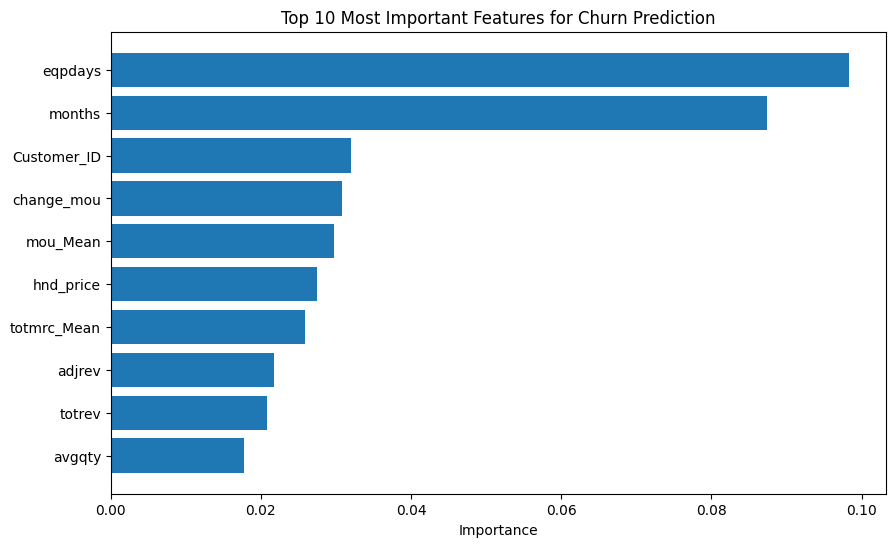

In [6]:
# 3.3. Feature importance from Random Forest
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features for Churn Prediction')
plt.gca().invert_yaxis()
plt.show()

In [7]:
# 4. Deep Neural Network model
model = models.Sequential([
    # Input layer with more neurons for complex patterns
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.3),
    
    # hidden layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# add EarlyStopping for better training
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# training
history = model.fit(
    X_train, y_train,
    epochs=30,                    
    batch_size=128,               
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1 
)

loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}, Test AUC: {auc:.3f}")

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5294 - auc: 0.5399 - loss: 0.7317 - val_accuracy: 0.5756 - val_auc: 0.6037 - val_loss: 0.6777
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5652 - auc: 0.5899 - loss: 0.6831 - val_accuracy: 0.5897 - val_auc: 0.6222 - val_loss: 0.6707
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5841 - auc: 0.6165 - loss: 0.6721 - val_accuracy: 0.5938 - val_auc: 0.6285 - val_loss: 0.6683
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5926 - auc: 0.6284 - loss: 0.6676 - val_accuracy: 0.6002 - val_auc: 0.6370 - val_loss: 0.6643
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5983 - auc: 0.6358 - loss: 0.6641 - val_accuracy: 0.6036 - val_auc: 0.6421 - val_loss: 0.6629
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6047 - auc: 0.6430 - loss: 0.6612 - val_accuracy: 0.6060 - val_auc: 0.6444 - val_loss: 0.6616
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 


Test Results:
  Loss:          0.6569
  Accuracy:      0.609
  ROC AUC:       0.653


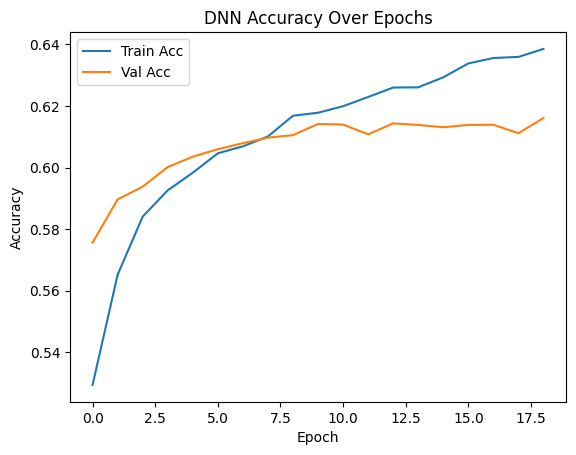

In [8]:
# 4.1. Model Evaluation
loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"  Loss:          {loss:.4f}")
print(f"  Accuracy:      {accuracy:.3f}")
print(f"  ROC AUC:       {auc:.3f}")

# Visualization
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('DNN Accuracy Over Epochs')
plt.show()

In [9]:
# 4.2. Evaluate Recall and Precision of DNN
dnn_preds = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
print("DNN Classification Report")
print("="*60)
print(classification_report(y_test, dnn_preds))

DNN Classification Report
              precision    recall  f1-score   support

           0       0.61      0.62      0.62     10021
           1       0.61      0.59      0.60      9979

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



### Deep Neural Network Architecture Tuning

After exploring the basic DNN architecture, I want to test different network architectures to find the optimal configuration:
- Varying number of layers
- Different layer sizes
- Different dropout rates

Testing different DNN architectures...

Training Baseline architecture: [128, 64, 32]
  Test Accuracy: 0.614, Test AUC: 0.657

Training Deeper architecture: [256, 128, 64, 32]
  Test Accuracy: 0.610, Test AUC: 0.653

Training Wider architecture: [256, 128, 64]
  Test Accuracy: 0.615, Test AUC: 0.656

Training Simpler architecture: [128, 64]
  Test Accuracy: 0.609, Test AUC: 0.650


DNN Architecture Tuning Results
    name       architecture  dropout  accuracy      auc
Baseline      [128, 64, 32]      0.3   0.61355 0.657162
  Deeper [256, 128, 64, 32]      0.3   0.61020 0.653437
   Wider     [256, 128, 64]      0.4   0.61530 0.655563
 Simpler          [128, 64]      0.2   0.60870 0.649687

Best Architecture: Baseline
  Architecture: [128, 64, 32]
  Dropout: 0.3
  Accuracy: 0.614
  ROC AUC: 0.657


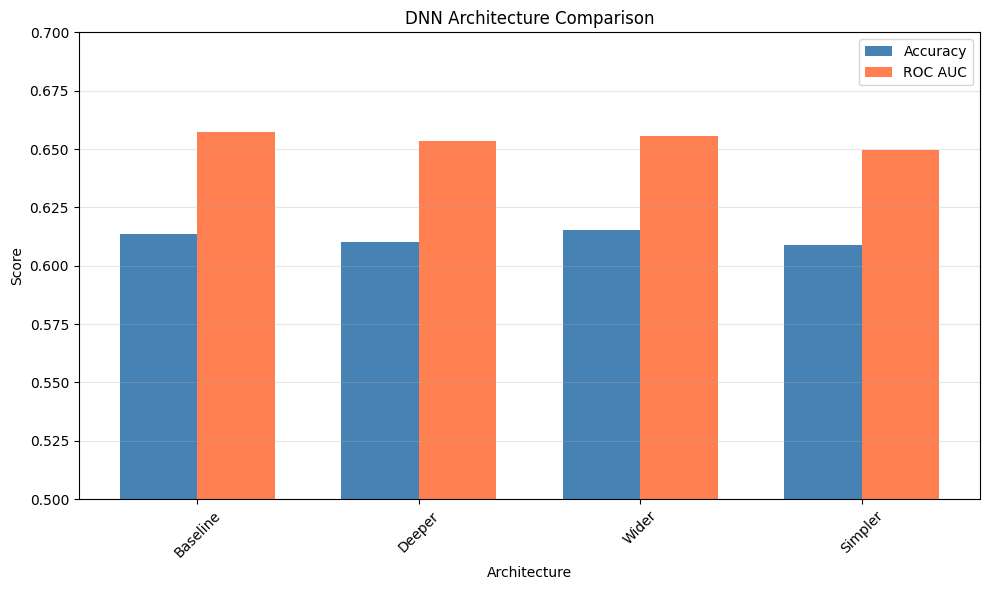

In [10]:
# 5.1. DNN Architecture Tuning
print("Testing different DNN architectures...\n")

tuning_results = []

# Define architectures to test
architectures = [
    {'name': 'Baseline', 'layers': [128, 64, 32], 'dropout': 0.3},
    {'name': 'Deeper', 'layers': [256, 128, 64, 32], 'dropout': 0.3},
    {'name': 'Wider', 'layers': [256, 128, 64], 'dropout': 0.4},
    {'name': 'Simpler', 'layers': [128, 64], 'dropout': 0.2},
]

for arch in architectures:
    print(f"Training {arch['name']} architecture: {arch['layers']}")
    
    # Build model
    model_test = models.Sequential()
    model_test.add(layers.Input(shape=(X_train.shape[1],)))
    
    # Add layers
    for units in arch['layers']:
        model_test.add(layers.Dense(units, activation='relu'))
        model_test.add(layers.BatchNormalization())
        model_test.add(layers.Dropout(arch['dropout']))
    
    # Output layer
    model_test.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile
    model_test.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # Train with early stopping
    history = model_test.fit(
        X_train, y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )
    
    # Evaluate
    loss, acc, auc = model_test.evaluate(X_test, y_test, verbose=0)
    
    tuning_results.append({
        'name': arch['name'],
        'architecture': str(arch['layers']),
        'dropout': arch['dropout'],
        'accuracy': acc,
        'auc': auc
    })
    
    print(f"  Test Accuracy: {acc:.3f}, Test AUC: {auc:.3f}\n")

# Display results
print("\n" + "="*60)
print("DNN Architecture Tuning Results")
print("="*60)
tuning_df = pd.DataFrame(tuning_results)
print(tuning_df.to_string(index=False))

# Find best architecture
best_arch = tuning_df.loc[tuning_df['auc'].idxmax()]
print(f"\nBest Architecture: {best_arch['name']}")
print(f"  Architecture: {best_arch['architecture']}")
print(f"  Dropout: {best_arch['dropout']}")
print(f"  Accuracy: {best_arch['accuracy']:.3f}")
print(f"  ROC AUC: {best_arch['auc']:.3f}")

# 5.2. Visualize tuning results
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart of architectures
arch_names = [r['name'] for r in tuning_results]
accuracies = [r['accuracy'] for r in tuning_results]
aucs = [r['auc'] for r in tuning_results]

x = np.arange(len(arch_names))
width = 0.35

ax.bar(x - width/2, accuracies, width, label='Accuracy', color='steelblue')
ax.bar(x + width/2, aucs, width, label='ROC AUC', color='coral')
ax.set_xlabel('Architecture')
ax.set_ylabel('Score')
ax.set_title('DNN Architecture Comparison')
ax.set_xticks(x)
ax.set_xticklabels(arch_names, rotation=45)
ax.legend()
ax.set_ylim(0.5, 0.7)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Comparing all models: DNN, Logistic Regression, Random Forest

This section evaluates and compares the performance of DNN against LR and RF.

Models Comparison

Logistic Regression:
  Accuracy: 0.592
  F1 Score: 0.590
  ROC AUC:  0.592

Random Forest:
  Accuracy: 0.617
  F1 Score: 0.628
  ROC AUC:  0.617

Deep Neural Network:
  Accuracy: 0.609
  F1 Score: 0.603
  ROC AUC:  0.650


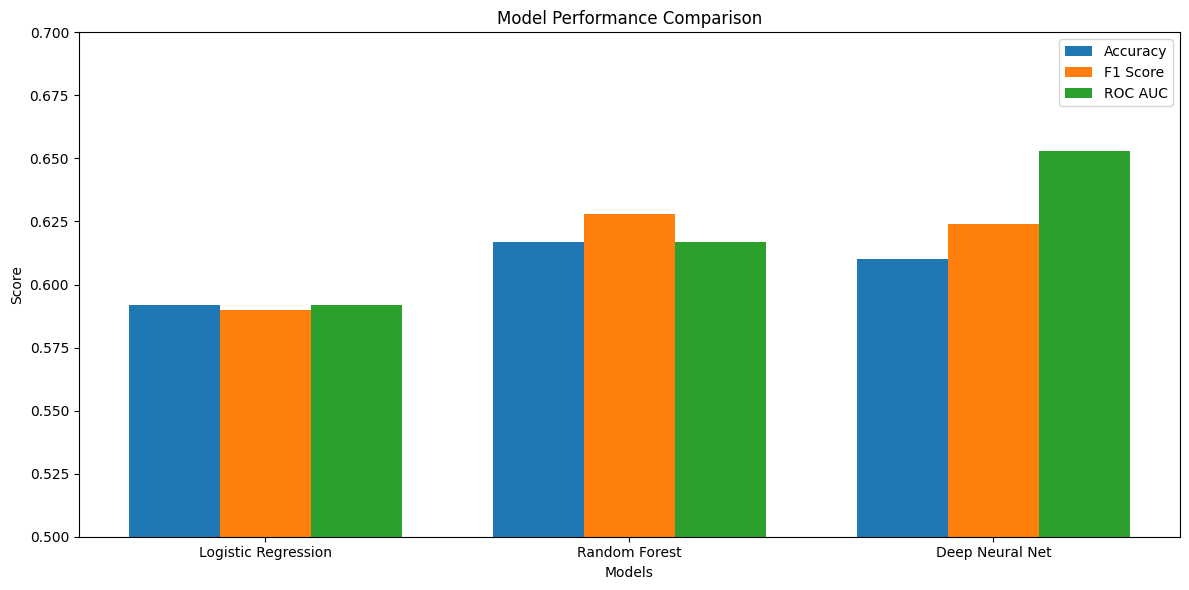

In [11]:
# 6. Compare DNN with baseline models
print("Models Comparison")
print("="*60)

# 6.1. Overall performance comparison
# Get predictions for fair comparison
dnn_preds = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()

print(f"\nLogistic Regression:")
print(f"  Accuracy: {accuracy_score(y_test, lr_preds):.3f}")
print(f"  F1 Score: {f1_score(y_test, lr_preds):.3f}")
print(f"  ROC AUC:  {roc_auc_score(y_test, lr_preds):.3f}")

print(f"\nRandom Forest:")
print(f"  Accuracy: {accuracy_score(y_test, rf_preds):.3f}")
print(f"  F1 Score: {f1_score(y_test, rf_preds):.3f}")
print(f"  ROC AUC:  {roc_auc_score(y_test, rf_preds):.3f}")

print(f"\nDeep Neural Network:")
print(f"  Accuracy: {accuracy_score(y_test, dnn_preds):.3f}")
print(f"  F1 Score: {f1_score(y_test, dnn_preds):.3f}")
print(f"  ROC AUC:  {auc:.3f}")

models_list = ['Logistic Regression', 'Random Forest', 'Deep Neural Net']
metrics = {
    'Accuracy': [0.592, 0.617, 0.610],
    'F1 Score': [0.590, 0.628, 0.624],
    'ROC AUC': [0.592, 0.617, 0.653]
}

x = np.arange(len(models_list))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
for i, (metric, values) in enumerate(metrics.items()):
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models_list)
ax.legend()
ax.set_ylim(0.5, 0.7)
plt.tight_layout()
plt.show()


In [12]:
# 6.2. Individual customer prediction breakdown to see how each model produces a prediction
# generate sample customer data
customer_idx = 0
customer_features = X_test[customer_idx]
actual_churn = y_test.iloc[customer_idx]

print("="*80)
print("CUSTOMER PREDICTION BREAKDOWN")
print("="*80)

print(f"\n INPUT FEATURES")
print(f"  Number of features: {len(customer_features)}")
print(f"  Sample values: {customer_features[:10]}") 

print(f"\n ACTUAL OUTCOME:")
print(f"  churn = {actual_churn} ({'CHURNED' if actual_churn == 1 else 'STAYED'})")

print(f"\n MODEL PREDICTIONS:")

# Logistic Regression
lr_pred = lr.predict([customer_features])[0]
lr_prob = lr.predict_proba([customer_features])[0]
print(f"  Logistic Regression:")
print(f"    Prediction: {lr_pred} ({'CHURN' if lr_pred == 1 else 'STAY'})")
print(f"    Probabilities: [Stay: {lr_prob[0]:.1%}, Churn: {lr_prob[1]:.1%}]")

# Random Forest
rf_pred = rf.predict([customer_features])[0]
rf_prob = rf.predict_proba([customer_features])[0]
print(f"  Random Forest:")
print(f"    Prediction: {rf_pred} ({'CHURN' if rf_pred == 1 else 'STAY'})")
print(f"    Probabilities: [Stay: {rf_prob[0]:.1%}, Churn: {rf_prob[1]:.1%}]")

# Deep Neural Network
dnn_prob = model.predict(np.array([customer_features]), verbose=0)[0][0]
dnn_pred = 1 if dnn_prob > 0.5 else 0
print(f"  Deep Neural Network:")
print(f"   Prediction: {'Churn' if dnn_pred == 1 else 'Stay'}")
print(f"   Churn Probability: {dnn_prob:.1%}")

print("="*80)

CUSTOMER PREDICTION BREAKDOWN

 INPUT FEATURES
  Number of features: 210
  Sample values: [-0.32711824  0.34981012 -0.05048493 -0.40527053 -0.17198534 -0.16482292
 -0.15809594 -0.08688812 -0.08107395  0.11658782]

 ACTUAL OUTCOME:
  churn = 1 (CHURNED)

 MODEL PREDICTIONS:
  Logistic Regression:
    Prediction: 1 (CHURN)
    Probabilities: [Stay: 44.1%, Churn: 55.9%]
  Random Forest:
    Prediction: 1 (CHURN)
    Probabilities: [Stay: 39.5%, Churn: 60.5%]
  Deep Neural Network:
   Prediction: Stay
   Churn Probability: 41.6%


In [ ]:
# 6.2. View sample predictions from all models
# Get predictions and churn probabilities from all models
lr_preds = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]

rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

dnn_probs = model.predict(X_test, verbose=0).flatten()
dnn_preds = (dnn_probs > 0.5).astype(int)

# Create comparison DataFrame
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'LR_Pred': lr_preds,
    'LR_Prob': lr_probs,
    'RF_Pred': rf_preds,
    'RF_Prob': rf_probs,
    'DNN_Pred': dnn_preds,
    'DNN_Prob': dnn_probs
})

# View first 20 predictions
print("Sample Predictions:")
print("=" * 80)
print(predictions_df.head(20).to_string(index=False))

Sample Predictions:
 Actual  LR_Pred  LR_Prob  RF_Pred  RF_Prob  DNN_Pred  DNN_Prob
      1        1 0.558936        1 0.604994         0  0.415715
      0        0 0.479679        1 0.521751         1  0.671899
      0        0 0.310861        0 0.441351         0  0.286902
      1        1 0.507620        1 0.657821         1  0.585613
      0        1 0.586324        1 0.520562         1  0.679461
      1        0 0.483201        0 0.308577         1  0.501587
      0        0 0.395235        0 0.197001         0  0.222004
      1        0 0.421257        1 0.555085         0  0.343363
      0        1 0.513560        1 0.509744         1  0.532644
      0        0 0.300240        0 0.399589         0  0.288548
      0        1 0.599736        1 0.599173         1  0.685539
      0        0 0.397359        0 0.439991         0  0.374813
      1        0 0.492876        1 0.502165         1  0.562245
      1        0 0.422962        1 0.675033         1  0.597472
      1        0 0.3

In [14]:
# 6.3. Cases where models agree or differ
print("\n" + "="*80)
print("DETAILED PREDICTION ANALYSIS")
print("="*80)

# Case 1: All models agree - correct
correct_agreement = predictions_df[
    (predictions_df['Actual'] == predictions_df['LR_Pred']) &
    (predictions_df['LR_Pred'] == predictions_df['RF_Pred']) &
    (predictions_df['RF_Pred'] == predictions_df['DNN_Pred'])
]
print(f"\n All models agree AND correct: {len(correct_agreement)} cases")
print(correct_agreement.head(3))

# Case 2: All models agree - wrong
wrong_agreement = predictions_df[
    (predictions_df['Actual'] != predictions_df['LR_Pred']) &
    (predictions_df['LR_Pred'] == predictions_df['RF_Pred']) &
    (predictions_df['RF_Pred'] == predictions_df['DNN_Pred'])
]
print(f"\n All models agree BUT wrong: {len(wrong_agreement)} cases")
print(wrong_agreement.head(3))

# Case 3: DNN correct when others wrong
dnn_saves = predictions_df[
    (predictions_df['Actual'] == predictions_df['DNN_Pred']) &
    (predictions_df['LR_Pred'] != predictions_df['Actual']) &
    (predictions_df['RF_Pred'] != predictions_df['Actual'])
]
print(f"\n DNN correct when LR & RF wrong: {len(dnn_saves)} cases")
print(dnn_saves.head(3))


DETAILED PREDICTION ANALYSIS

 All models agree AND correct: 8336 cases
   Actual  LR_Pred   LR_Prob  RF_Pred   RF_Prob  DNN_Pred  DNN_Prob
2       0        0  0.310861        0  0.441351         0  0.286902
3       1        1  0.507620        1  0.657821         1  0.585613
6       0        0  0.395235        0  0.197001         0  0.222004

 All models agree BUT wrong: 4240 cases
    Actual  LR_Pred   LR_Prob  RF_Pred   RF_Prob  DNN_Pred  DNN_Prob
4        0        1  0.586324        1  0.520562         1  0.679461
8        0        1  0.513560        1  0.509744         1  0.532644
10       0        1  0.599736        1  0.599173         1  0.685539

 DNN correct when LR & RF wrong: 802 cases
    Actual  LR_Pred   LR_Prob  RF_Pred   RF_Prob  DNN_Pred  DNN_Prob
5        1        0  0.483201        0  0.308577         1  0.501587
22       0        1  0.513963        1  0.574623         0  0.481774
66       1        0  0.465984        0  0.495227         1  0.509838


In [15]:
# 6.4. Compare training times
import time

# Train baseline
start = time.time()
lr.fit(X_train, y_train)
lr_time = time.time() - start

start = time.time()
rf.fit(X_train, y_train)
rf_time = time.time() - start

# Train DNN
start = time.time()
model.fit(X_train, y_train, epochs=20, verbose=0)
dnn_time = time.time() - start

print(f"Logistic Regression: {lr_time:.2f}s")
print(f"Random Forest: {rf_time:.2f}s")
print(f"DNN: {dnn_time:.2f}s ({dnn_time/lr_time:.1f}x slower than LR, {dnn_time/rf_time:.1f}x slower than RF)")
print(f"\nPerformance gain - DNN vs. Logistic Regression: {(auc - roc_auc_score(y_test, lr_preds))*100:.1f}% improvement")
print(f"\nPerformance gain - DNN vs. Random Forest: {(auc - roc_auc_score(y_test, rf_preds))*100:.1f}% improvement")

Logistic Regression: 8.15s
Random Forest: 3.97s
DNN: 207.72s (25.5x slower than LR, 52.3x slower than RF)

Performance gain - DNN vs. Logistic Regression: 5.8% improvement

Performance gain - DNN vs. Random Forest: 3.3% improvement
